In [1]:
import torch
from easyGPR_helper import set_gpytorch_settings, GPRModel
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
from easyGPR_helper import set_gpytorch_settings, GPRModel
from gpytorch.kernels import ScaleKernel, PolynomialKernel, PeriodicKernel, RBFKernel
from gpytorch.kernels import CosineKernel, MaternKernel, LinearKernel
from custom_kernels import RBFNonSeparableKernel

import skimage.io as skio
import skimage.color as skcolor
import skimage.transform as sktrans
import skimage.filters as skfilter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 4)   

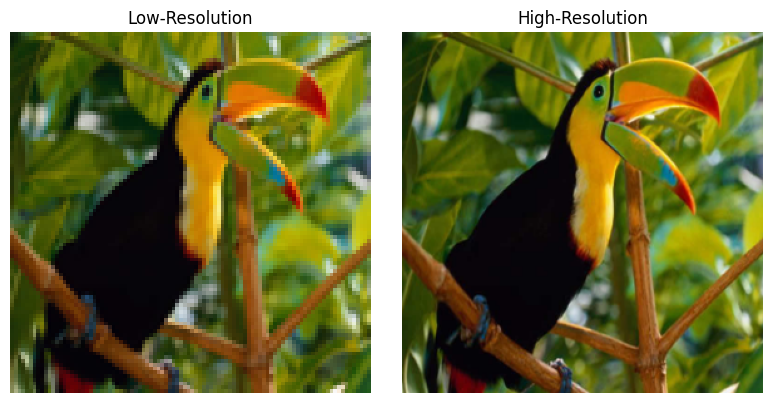

In [2]:
LR_img = skio.imread("images/toucan_LR.png")
HR_img = skio.imread("images/toucan_HR.png")

fig, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].imshow(LR_img)
ax[0].set_title("Low-Resolution")
ax[0].axis("off")

ax[1].imshow(HR_img)
ax[1].set_title("High-Resolution")
ax[1].axis("off")

plt.tight_layout()
plt.show()

In [3]:
print("LR shape:", LR_img.shape)
print("HR shape:", HR_img.shape)

LR shape: (96, 96, 3)
HR shape: (288, 288, 3)


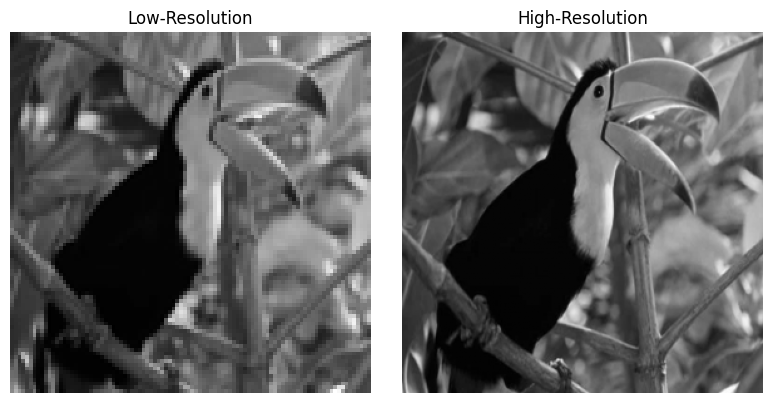

In [4]:
#Convert to Grayscale
LR_img_g = skcolor.rgb2gray(LR_img)
HR_img_g = skcolor.rgb2gray(HR_img)

fig, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].imshow(LR_img_g, cmap='gray')
ax[0].set_title("Low-Resolution")
ax[0].axis("off")

ax[1].imshow(HR_img_g, cmap='gray')
ax[1].set_title("High-Resolution")
ax[1].axis("off")

plt.tight_layout()
plt.show()

In [5]:
print("Gray LR shape:", LR_img_g.shape)
print("Gray HR shape:", HR_img_g.shape)

Gray LR shape: (96, 96)
Gray HR shape: (288, 288)


In [6]:
# # height, width = LR_img_g.shape

# pixel_list = []
# #3x3 Patch 
# for i in range(1, 3-1):
#     for j in range (1, 3-1):
#         display_patch = LR_img_g[i-1:i+2, j-1:j+2]
#         pixel_array = display_patch.flatten()
#         x_gray = np.delete(pixel_array, 4)
#         y_gray = pixel_array[4]
#         pixel_list.append(np.append(x_gray, y_gray))

# df = pd.DataFrame(pixel_list, columns=[f"x{i+1}" for i in range(8)] + ["y"])
# print(df)

### SRGPR Algorithm 1

In [7]:
#Upsampling w/ Bicubic Interpolation
upsampled_img = sktrans.resize(LR_img_g, (LR_img_g.shape[0]*3, LR_img_g.shape[1]*3), order = 3, preserve_range=True)

In [8]:
#Partition LR image for training data
kernel = ScaleKernel(MaternKernel(nu=0.5))
height, width = LR_img_g.shape

#Split into 2x2 Grid
patch_rows, patch_cols = 2, 2
patch_height = height / patch_rows
patch_width = width / patch_cols
overlap = 5

#Store GP Models
models = [[None for _ in range(patch_cols)] for _ in range(patch_rows)]

for i in range(patch_rows):
    for j in range(patch_cols):
        #define each patch dims
        row_start = int(max(0, i * patch_height - overlap))
        row_end = int(min(height, (i + 1) * patch_height + overlap))
        col_start = int(max(0, j * patch_width - overlap))
        col_end = int(min(width, (j + 1) * patch_width + overlap))

        patch = LR_img_g[row_start:row_end, col_start:col_end]

        x_list, y_list = [], []
        #3x3 Patch 
        for k in range(1, patch.shape[0] - 1):
            for l in range (1, patch.shape[1] - 1):
                grid = patch[k-1:k+2, l-1:l+2]
                grid_array = grid.flatten()
                x_intensities = np.delete(grid_array, 4)
                y_intensity = grid_array[4]
                x_list.append(x_intensities)
                y_list.append(y_intensity)

        x_train = np.array(x_list) #from L
        y_train = np.array(y_list).ravel() #from L

        #Train model
        model = GPRModel(train_x=x_train, train_y=y_train, kernel=kernel, scale_x=True)
        model.fit_model(training_iterations=10, lr=0.1)
        models[i][j] = model

Fitting complete.
--- 
--- final mll: -0.4352
--- num_params: 4
--- BIC: 1028.2103
Fitting complete.
--- 
--- final mll: -0.4449
--- num_params: 4
--- BIC: 1058.3816
Fitting complete.
--- 
--- final mll: -0.4293
--- num_params: 4
--- BIC: 1018.6010
Fitting complete.
--- 
--- final mll: -0.4391
--- num_params: 4
--- BIC: 1040.6925


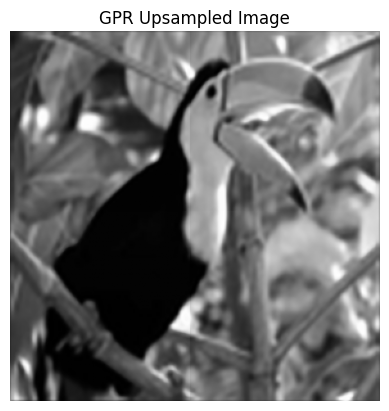

In [9]:
#Partition Upsampled image for test data
height_UL, width_UL = upsampled_img.shape

#Initialize
predicted_img_U = upsampled_img.copy()

patch_height_UL = height_UL / patch_rows
patch_width_UL = width_UL / patch_cols

for i in range(patch_rows):
    for j in range(patch_cols):
        row_start = int(max(0, i * patch_height_UL - overlap))
        row_end = int(min(height_UL, (i + 1) * patch_height_UL + overlap))
        col_start = int(max(0, j * patch_width_UL - overlap))
        col_end = int(min(width_UL, (j + 1) * patch_width_UL + overlap))

        patch = upsampled_img[row_start:row_end, col_start:col_end]

        x_list = []
        for k in range(1, patch.shape[0] - 1):
            for l in range(1, patch.shape[1] - 1):
                grid = patch[k-1:k+2, l-1:l+2]
                grid_array = grid.flatten()
                x_intensities = np.delete(grid_array, 4)
                x_list.append(x_intensities)

        x_test = np.array(x_list) #from H_b for H~
        
        model = models[i][j]
        pred = model.make_predictions(x_test, type='f', return_type='numpy') #gives H~
        y_pred = pred.mean
        
        y_pred = np.clip((y_pred - y_pred.min()) / (y_pred.max() - y_pred.min()), 0, 1)
        pred_patch = y_pred.reshape(patch.shape[0] - 2, patch.shape[1] - 2)
        predicted_img_U[row_start+1:row_end-1, col_start+1:col_end-1] = pred_patch

plt.imshow(predicted_img_U, cmap='gray')
plt.title("GPR Upsampled Image")
plt.axis("off") 
plt.show()

In [10]:
#Blur and Downsample
blurred_img = skfilter.gaussian(predicted_img_U)
dsampled_img = sktrans.resize(blurred_img, (int(blurred_img.shape[0]*(1/3)), int(blurred_img.shape[1]*(1/3))), preserve_range=True, anti_aliasing=True)

In [11]:
#Partition ~L image for training data
height, width = dsampled_img.shape

#Split into 2x2 Grid

#Store GP Models
models_L = [[None for _ in range(patch_cols)] for _ in range(patch_rows)]

for i in range(patch_rows):
    for j in range(patch_cols):
        #define each patch dims
        row_start = int(max(0, i * patch_height - overlap))
        row_end = int(min(height, (i + 1) * patch_height + overlap))
        col_start = int(max(0, j * patch_width - overlap))
        col_end = int(min(width, (j + 1) * patch_width + overlap))

        patch_L = dsampled_img[row_start:row_end, col_start:col_end]

        x_list_L, y_list_L = [], []
        #3x3 Patch 
        for k in range(1, patch_L.shape[0] - 1):
            for l in range (1, patch_L.shape[1] - 1):
                grid_L = patch_L[k-1:k+2, l-1:l+2]
                grid_array_L = grid_L.flatten()
                x_intensities_L = np.delete(grid_array_L, 4)
                y_intensity_L = grid_array_L[4]
                x_list_L.append(x_intensities_L) 
                y_list_L.append(y_intensity_L)

        x_train_L = np.array(x_list_L) #from L~
        y_train_L = np.array(y_list_L).ravel() #from L

        #Train model
        model_L = GPRModel(train_x=x_train_L, train_y=y_train_L, kernel=kernel, scale_x=True)
        model_L.fit_model(training_iterations=10, lr=0.1)
        models_L[i][j] = model_L

Fitting complete.
--- 
--- final mll: -0.4351
--- num_params: 4
--- BIC: 1030.6960
Fitting complete.
--- 
--- final mll: -0.4447
--- num_params: 4
--- BIC: 1051.3726
Fitting complete.
--- 
--- final mll: -0.4260
--- num_params: 4
--- BIC: 1013.4161
Fitting complete.
--- 
--- final mll: -0.4374
--- num_params: 4
--- BIC: 1042.0508


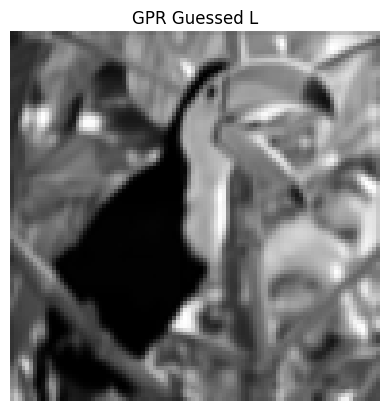

In [12]:
#Initialize 
predicted_img_D = dsampled_img.copy()

for i in range(patch_rows):
    for j in range(patch_cols):
        row_start = int(max(0, i * patch_height - overlap))
        row_end = int(min(height, (i + 1) * patch_height + overlap))
        col_start = int(max(0, j * patch_width - overlap))
        col_end = int(min(width, (j + 1) * patch_width + overlap))

        patch_DL = dsampled_img[row_start:row_end, col_start:col_end]

        x_list_DL = []
        for k in range(1, patch_DL.shape[0] - 1):
            for l in range(1, patch_DL.shape[1] - 1):
                grid_DL = patch_DL[k-1:k+2, l-1:l+2]
                grid_array_DL = grid_DL.flatten()
                x_intensities_DL = np.delete(grid_array_DL, 4)
                x_list_DL.append(x_intensities_DL)

        x_L_test = np.array(x_list_DL)
        
        model_L = models_L[i][j]
        pred_DL = model_L.make_predictions(x_L_test, type='f', return_type='numpy')
        y_pred_DL = pred_DL.mean
        
        y_pred_DL = np.clip((y_pred_DL - y_pred_DL.min()) / (y_pred_DL.max() - y_pred_DL.min()), 0, 1)
        pred_patch_DL = y_pred_DL.reshape(patch_DL.shape[0] - 2, patch_DL.shape[1] - 2)
        predicted_img_D[row_start+1:row_end-1, col_start+1:col_end-1] = pred_patch_DL

plt.imshow(predicted_img_D, cmap='gray')
plt.title("GPR Guessed L")
plt.axis("off") 
plt.show()

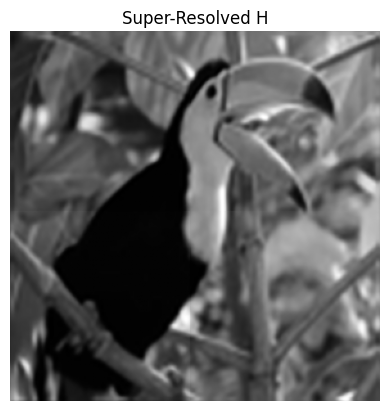

In [13]:
height_H, width_H = upsampled_img.shape
predicted_img_H = upsampled_img.copy()

for i in range(patch_rows):
    for j in range(patch_cols):
        row_start = int(max(0, i * patch_height_UL - overlap))
        row_end = int(min(height_H, (i + 1) * patch_height_UL + overlap))
        col_start = int(max(0, j * patch_width_UL - overlap))
        col_end = int(min(width_H, (j + 1) * patch_width_UL + overlap))

        patch_H = upsampled_img[row_start:row_end, col_start:col_end]

        x_list_H = []
        for k in range(1, patch_H.shape[0] - 1):
            for l in range(1, patch_H.shape[1] - 1):
                grid_H = patch_H[k-1:k+2, l-1:l+2]
                grid_array_H = grid_H.flatten()
                x_intensities_H = np.delete(grid_array_H, 4)
                x_list_H.append(x_intensities_H)

        x_test_H = np.array(x_list_H) #from H~
        model_L = models_L[i][j]
        pred_H = model_L.make_predictions(x_test_H, type='f', return_type='numpy')
        y_pred_H = pred_H.mean #gives H

        y_pred_H = np.clip((y_pred_H - y_pred_H.min()) / (y_pred_H.max() - y_pred_H.min()), 0, 1)
        pred_patch_H = y_pred_H.reshape(patch_H.shape[0] - 2, patch_H.shape[1] - 2)
        predicted_img_H[row_start+1:row_end-1, col_start+1:col_end-1] = pred_patch_H

plt.imshow(predicted_img_H, cmap='gray')
plt.title("Super-Resolved H")
plt.axis("off")
plt.show()

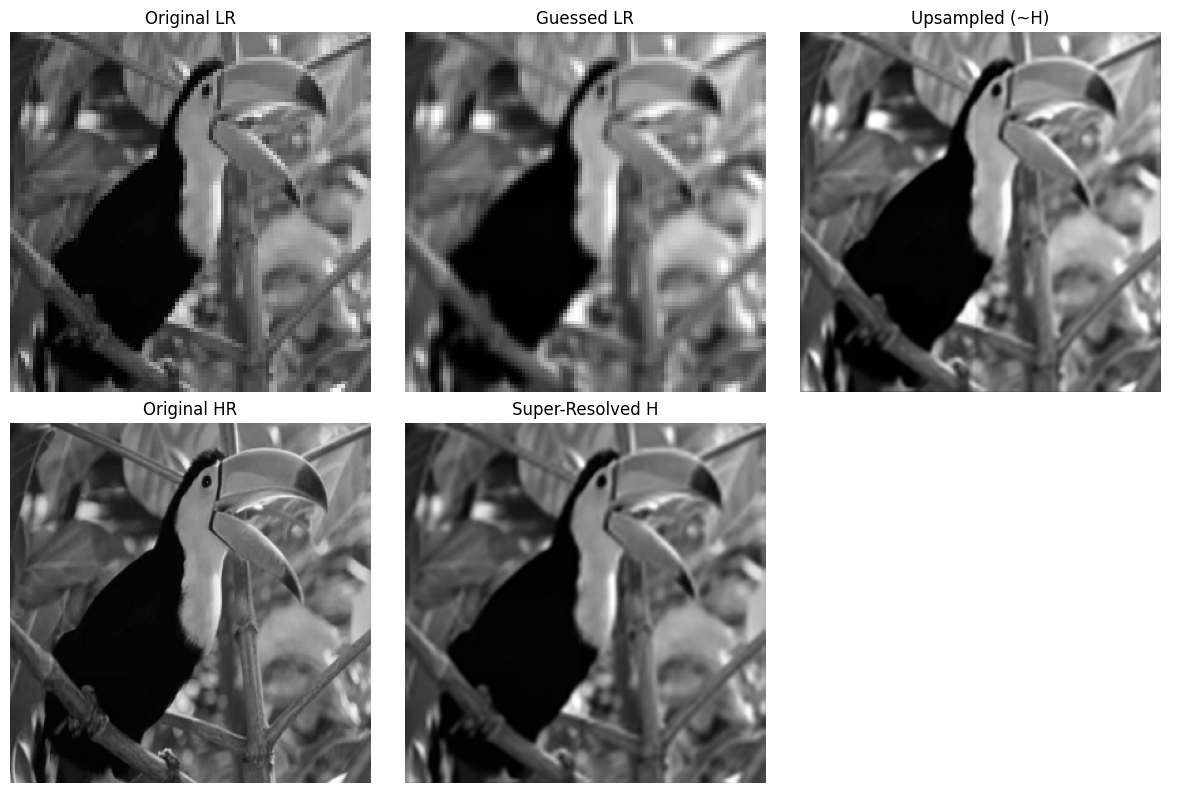

In [14]:
fig, ax = plt.subplots(2,3, figsize=(12, 8))
ax[0, 0].imshow(LR_img_g, cmap='gray')
ax[0, 0].set_title("Original LR")
ax[0, 0].axis('off')

ax[0, 1].imshow(predicted_img_D, cmap='gray')
ax[0, 1].set_title("Guessed LR")
ax[0, 1].axis('off')

ax[0, 2].imshow(predicted_img_U, cmap='gray')
ax[0, 2].set_title("Upsampled (~H)")
ax[0, 2].axis('off')

ax[1, 0].imshow(HR_img_g, cmap='gray') 
ax[1, 0].set_title("Original HR")
ax[1, 0].axis('off')

ax[1, 1].imshow(predicted_img_H, cmap='gray')
ax[1, 1].set_title("Super-Resolved H")
ax[1, 1].axis('off')

ax[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Performance Metrics